In [14]:
# 1.模型
# 1. 类别预测层
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    """
        +1 是背景类 
        out_channal: 预测总像素数*每个像素的锚框*（每个锚框预测的类型+背景类）
        图像分类，只预测分类情况，所有接全连接，这里单个像素的预测结果太多，就用多个通道来存
    """
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)




In [15]:
# 1.2 边界框预测层
# 边界框预测层的设计与类别预测层的设计类似。 唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是个类别
def bbox_predictor(num_inputs, num_anchors):
    """
        在目标检测的任务中，每个锚框，我们需要预测它与对应的目标的位置差异，通常称为"边界回归"。
        这种预测需要4个值，水平方向偏移，垂直方向偏移量，宽度缩放因子，高度缩放因子
        因此，需要四个输出节点来对这四个值进行预测
        num_anchors * 4 表示输出通道为 num_anchors * 4，即每个锚框需要4个输出节点来进行边框回归的预测
    """
    return nn.Conv2d(num_inputs, 
                     num_anchors * 4, 
                     kernel_size=3, padding=1)

In [16]:
# 1.3 连结多尺度的预测
# 正如我们所提到的，单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量。 
# 在不同的尺度下，特征图的形状或以同一单元为中心的锚框的数量可能会有所不同。 因此，不同尺度下预测输出的形状可能会有所不同
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [17]:
# 正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 
# 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式
def flatten_pred(pred):
    # 将通道放到最后，再拉成2d矩阵
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [18]:
# 1.4 高和宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [19]:
# 1.5 基本网络
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [20]:
# 1.6 完整的模块
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

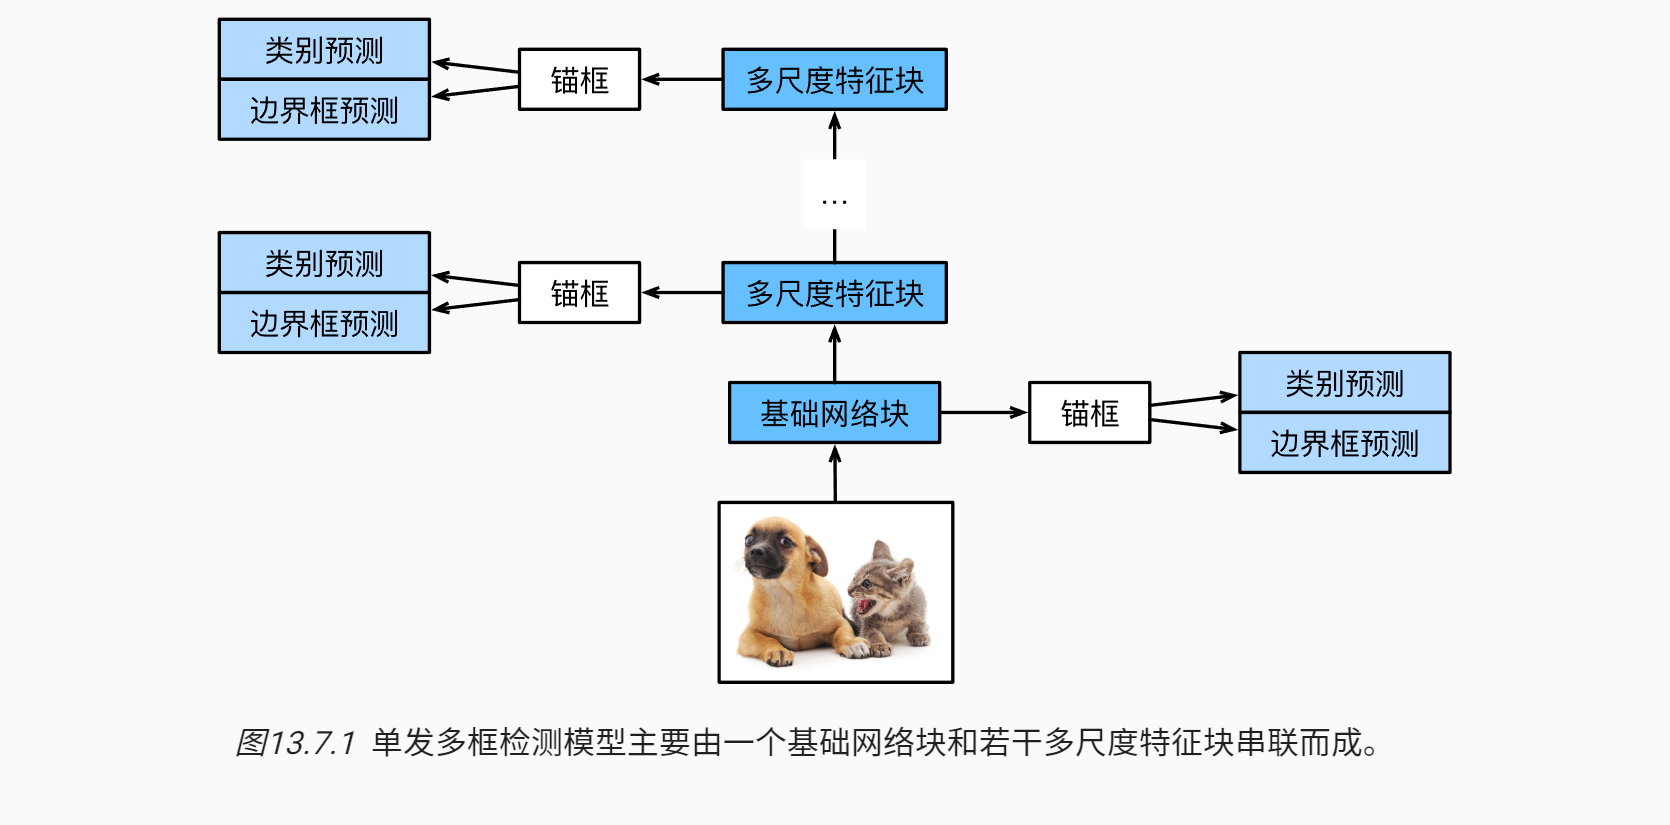

In [21]:
# 为每个块定义前向计算
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """
        在目标检测的模型中，通常会使用由多个不同层（块）组成的网络架构。
        每个块可能包含卷积层、池化层、激活函数等，用于提取不同级别的特征。
        模型的前向计算是将输入数据从网络的输入层传递到输出层的过程
        """
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [22]:
# 超参数
sizes = [[0.2, 0.272], 
         [0.37, 0.447], 
         [0.54, 0.619], 
         [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [23]:
# 定义完整的模型
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [24]:
# 创建一个模型实例，然后使用它执行前向计算
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [25]:
# 2.模型训练
# 2.1 读取数据集和初始化
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [26]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [27]:
# 2.2 定义损失函数和评价函数

# 初始化分类损失
cls_loss = nn.CrossEntropyLoss(reduction='none')
# 初始化边界框回归损失
bbox_loss = nn.L1Loss(reduction='none')


"""
    用于目标检测的损失函数，结合两个不同的损失组成部分：分类损失和边界框回归损失
    该损失函数的目的是训练一个能够在图像中检测和分类目标的模型
"""
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """
        cls_preds: 预测的每个锚框的类别得分
        cls_labels: 每个锚框的实际类别标签
        bbox_preds: 预测的每个锚框的边界框回归值
        bbox_labes: 每个锚框的实际边界框回归值
        bbox_masks: 二进制掩码，用来指示那些锚框是正样本和哪些是负样本 

    """
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox


In [28]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

KeyboardInterrupt: 

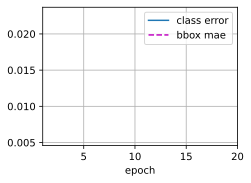

In [29]:
# 2.3 训练模型
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')